This notebook requires some packages which may not be installed by default:

* numpy
* scipy
* scikit-learn
* seaborn
* hdbscan (can be ommitted if only the k-means algorithm is used)

In [1]:
%matplotlib nbagg
import matplotlib
from matplotlib.lines import Line2D
import numpy as np
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from hdbscan import HDBSCAN

matplotlib.rcParams.update({'font.size': 12})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/home/andi/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/andi/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/andi/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models

## Atomic environment descriptor analysis (H2O CoM)

### Introduction

The overall goal of this analysis is to show qualitatively whether there is a correlation between the raw atomic environment descriptors (and their derivatives) and the atomic forces. If no or very little correlation can be found we can assume that the descriptors do not encode enough information to construct a (free) energy landscape. On the other hand, if "similar" descriptors correspond to "similar" forces there is a good chance that a machine learning algorithm is capable of detecting this link and a machine learning potential can be fitted.

### Method

In order to find a possible correlation between descriptors and forces the following approach is used: First, a clustering algorithm (k-means or HDBSCAN) searches for groups in the high-dimensional descriptor space of all atoms. Then, for every detected cluster the statistical distribution of the corresponding atomic forces is compared to the statistics of all remaining atomic forces. A hypothesis test (Welch's t-test) is applied to decide whether the link between descriptors and forces is statistically significant. The percentage of clusters which show a clear link is then an indicator for a good descriptor-force correlation. See the explanations below for further details on the individual steps.

In [2]:
# Some global variables needed throughout the script:
extract_element = "Cm"      # Determines which atoms to use for analysis in multicomponent systems.
extract_component = 0       # Which force component to analyze (0 = x, 1 = y, 2 = z)
extract_descriptor = "dGdx" # Which descriptor set to use ("G" ... symmetry functions, "dGd(x,y,z)" ... SF derivatives)
pvalue_max = 5.73303143e-07 # Max p-value allowed for statistical test (5 sigma, 3 sigma = 0.002699796063)

First, a simple function to read in the atomic forces from an _n2p2_ / _RuNNer_ data set file ("`input.data`"). Only atoms of a specific element are considered (argument `element`). Note, that the whole analysis can only be performed for a single element at a time because it makes no sense to search for similarities in the environments of different species. The functions returns a 2-dimensional `numpy` array. The first index is a running atom number, the second index denotes the x,y and z-component (0, 1, 2). Note, that the returned array is unaware of the original arrangement of atoms in different structures.

In [3]:
def read_forces(file_name="input.data", element="H"):
    data = []
    f = open(file_name, "r")
    for line in f:
        if line.split()[0] == "begin":
            natoms = 0
        elif line.split()[0] == "atom":
            natoms += 1
            if line.split()[4] == element:
                data.append(np.array([float(number) for number in line.split()[7:10]]))
        else:
            pass
    f.close()
    return np.array(data)

Now, let's read in a file and extract all atoms of the given element (see `extract_element` global variable above). The shape of the returned array should show a $N_\text{atoms} \times 3$ matrix.

**WARNING:** Be careful when using huge data sets ($N_\text{atoms} \gg 10^4$) because the clustering algorithms below may become very slow (especially HDBSCAN).

In [4]:
forces = read_forces("input.data", extract_element)
print(np.shape(forces))

(6840, 3)


Next, we have a look at the force distributions in the data set. If the data set is taken from an MD simulation we expect a Gaussian-like distribution around zero.

<f_x> :  8.62E-19 +/- 4.38E-03
<f_y> : -1.30E-18 +/- 4.23E-03
<f_z> : -1.03E-19 +/- 4.29E-03


<IPython.core.display.Javascript object>


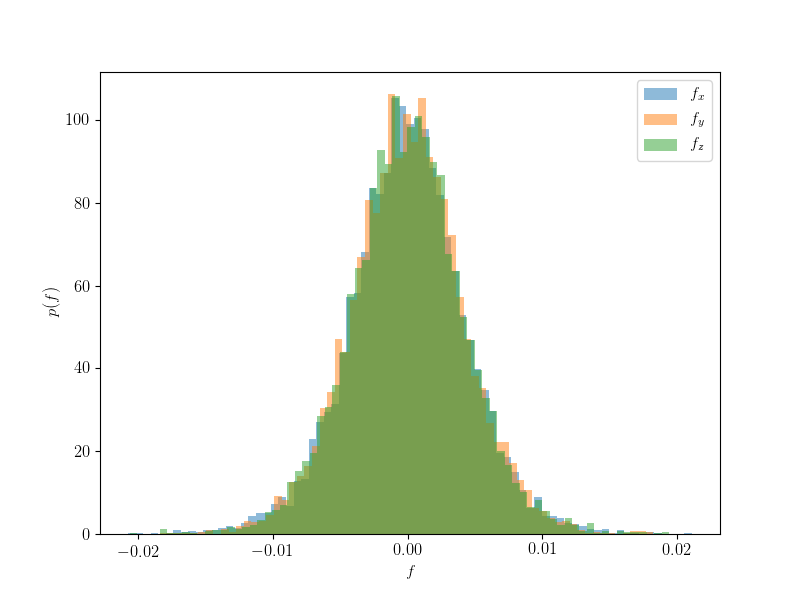

In [5]:
print("<f_x> : {0:9.2E} +/- {1:8.2E}".format(np.mean(forces.T[0]), np.std(forces.T[0], ddof=1)))
print("<f_y> : {0:9.2E} +/- {1:8.2E}".format(np.mean(forces.T[1]), np.std(forces.T[1], ddof=1)))
print("<f_z> : {0:9.2E} +/- {1:8.2E}".format(np.mean(forces.T[2]), np.std(forces.T[2], ddof=1)))

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.hist(forces.T[0], bins='auto', density=1, alpha=0.5, label=r'$f_x$')
ax.hist(forces.T[1], bins='auto', density=1, alpha=0.5, label=r'$f_y$')
ax.hist(forces.T[2], bins='auto', density=1, alpha=0.5, label=r'$f_z$')
ax.legend(loc='best')
ax.set_xlabel(r'$f$')
ax.set_ylabel(r'$p(f)$')
fig.savefig(f"force_histogram_{extract_element}.pdf")
fig.savefig(f"force_histogram_{extract_element}.png", dpi=300)

Up until now we have just prepared the atomic forces and we still need to read in the atomic environment descriptors. Here is a little excursion on how to prepare this data with _n2p2_ :

### nnp-sfclust

With _n2p2_ it is possible to create files which contain atomic environment data in the form of symmetry functions and their derivatives. More specifically, the tool `nnp-sfclust` provides the files "`atomic-env.G`" and "`atomic-env.dGd?`" (where `?` is all of `x`, `y` and `z`). With a given data set in "`input.data`" and symmetry function definitions (and scaling information) in "`input.nn`" and "`scaling.data`" the tool can be used with these command line arguments:

```
mpirun -np 4 nnp-sfclust <nbins> <ncutij>
```
where
```
<nbins> .....Number of symmetry function histogram bins.
<ncutij> ... Maximum number of neighbor symmetry functions written (for each element combination).
```

The parameter `nbins` is irrelevant for our task (set it e.g. to 500). The remaining parameters `ncut` (one for each element combination present, where `i` is the central atom's element and `j` is the neighbor's element, sorted according to increasing atomic number) determine the length of the atomic environment descriptor vector. If set to zero for all elements the output files will just contain the symmetry functions (and their derivatives) for each atom (one atom per line, columns correspond to different symmetry functions). However, a more detailed description of each atoms' surroundings can be provided if we include also symmetry functions of close-by neighbors. In particular, considering the HDNNP expression for forces,

$$
F_{i,\alpha} = - \sum_{j=0}^{N_\text{atoms}} \sum_{k=0}^{N_\text{sym.func.}} \frac{\partial E_j}{\partial G_{j,k}} \frac{\partial G_{j,k}}{\partial x_{i, \alpha}},
$$

it becomes clear that not only the symmetry function derivatives of the central atom $i$ but also those of neighboring atoms are relevant. Hence, we can add this information in the `atomic-env...` files as additional columns. Note however, that the total number of columns must be identical for all atoms of the same species because otherwise the descriptor vectors cannot be compared by the clustering algorithm. Also, it is crucial that the data order is consistent. In accordance with these requirements the tool `nnp-sfclust` writes the symmetry functions to `atomic-env.G` in the following way (one atom per row):

$$
S(i) \quad \vec{G}_{i} \quad \vec{G}_{n^{S_1}(i, 1)} \quad \ldots \quad \vec{G}_{n^{S_1}(i, \texttt{ncut}{S(i)S_1})} \quad \vec{G}_{n^{S_2}(i, 1)} \quad \ldots \quad \vec{G}_{n^{S_2}(i, \texttt{ncut}{S(i)S_2})} \quad \ldots,
$$

where

  * $S(i)$ ... Element string of atom $i$, e.g. `H`,
  * $\vec{G}_{i}$ ... Symmetry functions of atom $i$ as a row vector,
  * $S_j$ ... Element string of the $j$th element (sorted according to atomic number), e.g. $S_2 = $ `O` in water,
  * $n^{S_j}(i, k)$ ... a function returning the index of the $k$th nearest neighbor (sorted according to distance) of atom $i$ and of element $S_j$.

Similarly, the symmetry function derivatives in $x$, $y$ and $z$ direction are written to `atomic-env.dGdx`, `atomic-env.dGdy` and `atomic-env.dGdz`, respectively:

$$
S(i) \quad \frac{\partial \vec{G}_{i}}{\partial x_{i, \alpha}} \quad \frac{\partial \vec{G}_{n^{S_1}(i, 1)}}{\partial x_{i, \alpha}} \quad \ldots \quad \frac{\partial \vec{G}_{n^{S_1}(i, \texttt{ncut}{S(i)S_1})}}{\partial x_{i, \alpha}} \quad \frac{\partial \vec{G}_{n^{S_2}(i, 1)}}{\partial x_{i, \alpha}} \quad \ldots \quad \frac{\partial \vec{G}_{n^{S_2}(i, \texttt{ncut}{S(i)S_2})}}{\partial x_{i, \alpha}} \quad \ldots,
$$

where $\alpha = \{0, 1, 2\}$ and $x_{i, 0} = x_i, x_{i, 1} = y_i, x_{i, 2} = z_i$.

Hence, the `ncutij` command line parameters determine for each element combination how many of the closest neighbors are included. Consider for example a water data set where you want to extract the symmetry function information from the first (and second) neighbor shell. First, extract the number of nearest neighbors from the radial distribution function and use them when calling `nnp-sfclust`:

```
mpirun -np 4 nnp-sfclust 500 6 2 4 4
```

Since elements are always sorted according to their atomic number the neighbor cutoffs here are read in this order:

```
mpirun -np 4 nnp-sfclust 500 HH HO OH OO
```

or in words:

  * central atom H: print out information from 6 closest H and 2 closest O neighbors
  * central atom O: print out information from 4 closest H and 4 closest O neighbors
  
**WARNING:** Do not run the `nnp-sfclust` tool on large data sets as it will create HUGE files!

Next, here is a little function to read in the symmetry function files. Again, only atoms of a specified element are extracted.

In [6]:
def read_sf_data(file_name="atomic-env.G", element="H"):
    sf = []
    f = open(file_name, "r")
    for line in f:
        if line.split()[0] == element:
            sf.append(np.array([float(number) for number in line.split()[1:]]))
    f.close()    
    return np.array(sf)

When applying the above function to an actual data set we end up with a large numpy array with dimensions $N_\text{atoms} \times N_d$, where $N_d$ is the total number of atomic environment descriptors per atom (depends on the symmetry function setup and neighbor cutoffs picked by `nnp-sfclust`).

**CHECK:** The number of atoms here and above (when reading in the forces) must match!

In [7]:
sf = read_sf_data("atomic-env." + extract_descriptor, extract_element)
print(np.shape(sf))

(6840, 60)


**OPTIONAL:** The next two code cells can be excluded from execution, the visualization is not required for the analysis.

We can visualize the distribution of data points in the high-dimensional symmetry function space making use of a dimensionality-reduction algorithm (t-SNE). First, we need to prepare the projection which takes some time, especially for larger data sets. To limit the computational effort the data set is automatically sparsified if the number of points exceeds the given threshold in `vis_typ_points`.

In [8]:
# Typical number of data points for t-SNE visualization.
vis_typ_points = 2500

# Automatic sparsification
vis_sp = 1
if len(sf) > vis_typ_points:
    vis_sp = int(len(sf)/float(vis_typ_points))

if vis_sp > 1:
    print("NOTE: Using only every {0:d}th point for t-SNE visualization!\n".format(vis_sp))

%time projection = TSNE().fit_transform(sf[::vis_sp])

NOTE: Using only every 2th point for t-SNE visualization!

CPU times: user 17 s, sys: 446 µs, total: 17 s
Wall time: 17 s


Next, here are the data points arranged in 2 dimensions:

<IPython.core.display.Javascript object>


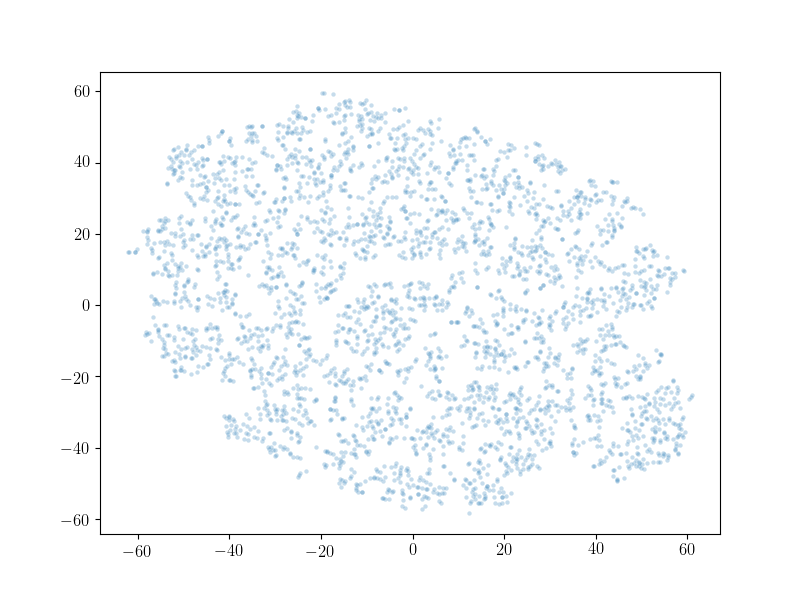

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.scatter(*projection.T, s=10, linewidth=0, alpha=0.25)

Next we set up a clustering algorithm. There are of course many algorithms available, see the documentation of _scikit-learn_. "k-means" is a simple and fast choice but requires the user to specify beforehand how many clusters should be found. A more sophisticated and modern algorithm is "HDBSCAN" (requires an extra package) which allows tuning via two parameters (`min_cluster_size` and `min_samples`, see their doc page). With HDBSCAN it is not guarantueed that always clusters are found.

In [10]:
#clustering = HDBSCAN(min_cluster_size=50, min_samples=1)
#clustering = HDBSCAN()
clustering = KMeans(n_clusters=10)

Finally, we can perform the cluster analysis:

In [11]:
%time clustering.fit(sf)

CPU times: user 767 ms, sys: 3.93 ms, total: 771 ms
Wall time: 774 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Most clustering algorithms provide the output in the `labels_` variable which we can use to build a list of clusters and the corresponding atom indices:

In [12]:
cluster_indices_dict = {}
for i,l in enumerate(clustering.labels_):
    try:
        cluster_indices_dict[l].extend([i])
    except KeyError:
        cluster_indices_dict[l] = [i]

cluster_indices = []
for i in sorted(cluster_indices_dict.keys()):
    cluster_indices.append([i, cluster_indices_dict[i]])
    
num_clusters = len(cluster_indices)
# HDBScan may not always assign a cluster label (label = -1 in this case).
# Remove this list of indices from the beginning of the array.
if cluster_indices[0][0] == -1:
    num_clusters -= 1
    cluster_indices = cluster_indices[1:]

if num_clusters == 0:
    print("WARNING: No clusters found!")
elif cluster_indices[-1][0] + 1 != num_clusters:
    print("WARNING: Some cluster indices were not found!")
print("Number of clusters: {0:d}".format(num_clusters))

Number of clusters: 10


In [13]:
# Preview color palette
#sns.palplot(sns.color_palette("hls", num_clusters))
# Spectral, rainbow, hls, hsv, gist_rainbow

**OPTIONAL:** Now that we have found some symmetry function clusters we can reuse the t-SNE visualization to check how the clusters look like:

NOTE: Using only every 2th point for t-SNE visualization!



<IPython.core.display.Javascript object>


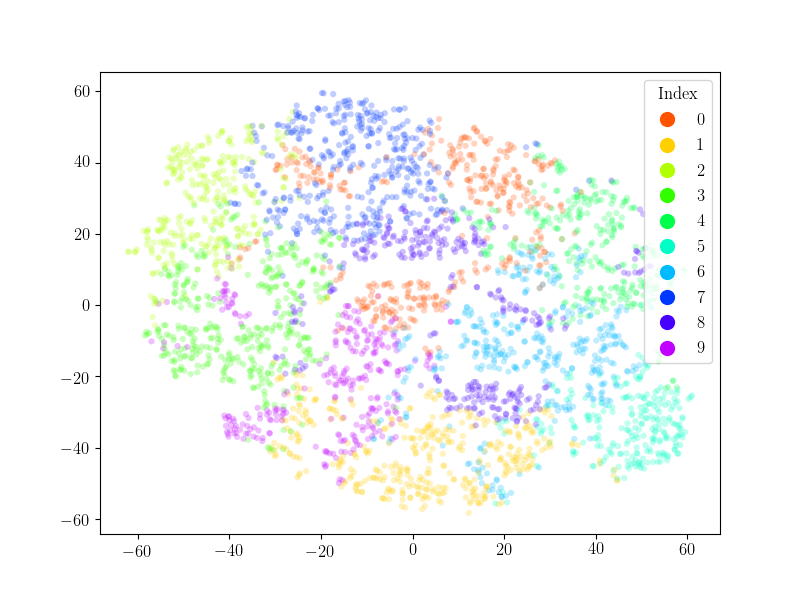

In [14]:
if vis_sp > 1:
    print("NOTE: Using only every {0:d}th point for t-SNE visualization!\n".format(vis_sp))

color_palette = sns.color_palette("gist_rainbow", num_clusters)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clustering.labels_[::vis_sp]]
# Only HDBSCAN provides probabilities_ information.
try:
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clustering.probabilities_[::vis_sp])]
except AttributeError:
    cluster_member_colors = cluster_colors

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
scatter = ax.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)
legend_elements = [Line2D([0], [0], marker='o', color="white", markerfacecolor=color_palette[i], label='{0:d}'.format(i), markersize=12) for i in range(len(color_palette))]
ax.legend(handles=legend_elements, loc='best', title="Index")
fig.savefig(f"tsne_visualization_{extract_element}.pdf")
fig.savefig(f"tsne_visualization_{extract_element}.png", dpi=300)

Now comes the actual analysis... we loop over all clusters and for each one we perform a statistical test. First, the forces belonging to a cluster are grouped (`f_clust`) and excluded from the remaining set (`f_excl`). These two sets are then compared with Welch's t-test (`stats.ttest_ind(equal_var=False)`), where the null hypothesis is that they have an equal mean value. Here, there are two possible outcomes:

  1. The null hypothesis is **accepted** (technically "failed to reject", p-value > `pvalue_max`):  
  
  We cannot distinguish the distributions (well, at least the mean is the same). Hence, the atom indices obtained from clustering their symmetry function vectors are not distinguishable from a randomly picked subset of indices. In other words, similar symmetry functions do not correspond to similar atomic forces (only exception: forces close to the overall mean force, usually zero)
  
  
  2. The null hypothesis is **rejected** (p-value < `pvalue_max`):
  
  The distribution of forces is different for the two subsets. Therefore we can argue that the symmetry function clusters correspond to similar atomic environments and hence similar forces different from the overall mean.

Of course we hope for many occurences of case (2)... hence, we count their percentage with respect to all tests.

In order to visualize the results we can plot histograms for each cluster. The grey histogram is the distribution of forces in the "remaining" set. A green histogram of the cluster forces is plotted if the null hypothesis is "successfully" rejected (case (2)), a red one otherwise.

<IPython.core.display.Javascript object>


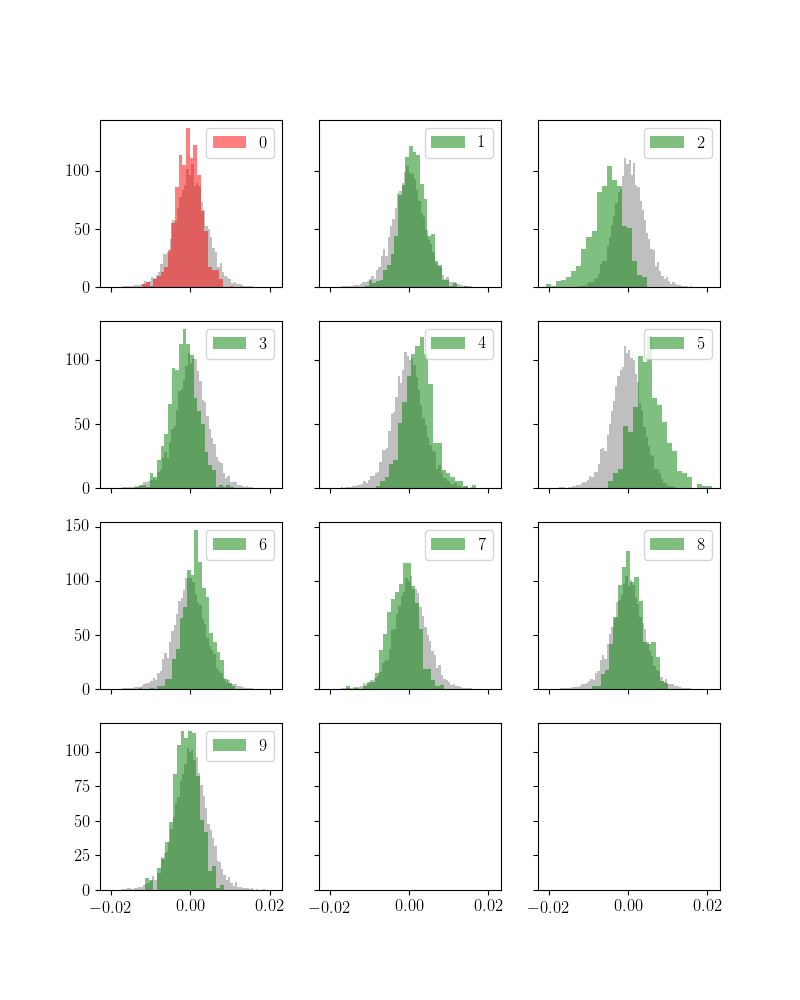

Cluster    0 (size   744): ACCEPTED p = 9.05E-06
Cluster    1 (size   799): rejected p = 1.62E-15
Cluster    2 (size   593): rejected p = 5.89E-133
Cluster    3 (size   843): rejected p = 1.23E-41
Cluster    4 (size   620): rejected p = 4.03E-53
Cluster    5 (size   544): rejected p = 1.23E-127
Cluster    6 (size   717): rejected p = 6.16E-36
Cluster    7 (size   787): rejected p = 3.19E-35
Cluster    8 (size   625): rejected p = 2.00E-08
Cluster    9 (size   568): rejected p = 1.20E-14
-----------------------------------
Number of clusters with statistically differing mean force: 9 (90.00 %)


In [15]:
# Setup for array of histograms.
ncols = 3
nrows = int(np.ceil(num_clusters / float(ncols)))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex="col", sharey="row")
fig.set_size_inches(8, 2.5*nrows)

count_rejected = 0
for i in range(num_clusters):
    a = extract_component
    indices = np.array(cluster_indices[i][1])
    f_all = forces.T[a]
    f_excl = forces.T[a][~np.isin(range(len(forces.T[a])), indices)]
    f_clust = forces.T[a][indices]
    if len(forces.T[a]) != len(f_excl) + len(f_clust):
        print("WARNING: Something went wrong.")
    if len(f_clust) > 1:
        ttest = stats.ttest_ind(f_excl, f_clust, equal_var=False)
    ax = fig.axes[i]
    ax.hist(f_excl,  bins='auto', density=1, color="grey", alpha=0.5)
    if len(f_clust) <= 1 or ttest.pvalue > pvalue_max:
        color = "red"
        print("Cluster {0:4d} (size {1:5d}): ACCEPTED p = {2:.2E}".format(i, len(f_clust), ttest.pvalue))
    else:
        color = "green"
        print("Cluster {0:4d} (size {1:5d}): rejected p = {2:.2E}".format(i, len(f_clust), ttest.pvalue))
        count_rejected += 1
    ax.hist(f_clust, bins='auto', density=1, color=color, alpha=0.5, label="{0:d}".format(i))
    ax.legend(loc="upper right")
print("-----------------------------------")
print("Number of clusters with statistically differing mean force: {0:d} ({1:.2f} %)".format(count_rejected, count_rejected * 100.0 / num_clusters))
fig.savefig(f"cluster_histograms_{extract_element}.pdf")
fig.savefig(f"cluster_histograms_{extract_element}.png", dpi=300)

The above calculation will give us a good impression of the atomic environment descriptor quality. Still, one could argue that the result could look different if other cluster search parameters were chosen. Luckily, with k-means we can easily repeat the calculation for many desired number of clusters.

**WARNING:** This may take a while...

In [16]:
%%time 
cluster_numbers = [3, 5,10, 20, 50, 100, 150, 200]
cluster_results = []
for n_clusters in cluster_numbers:
    clustering = KMeans(n_clusters=n_clusters)
    clustering.fit(sf)
    cluster_indices_dict = {}
    for i,l in enumerate(clustering.labels_):
        try:
            cluster_indices_dict[l].extend([i])
        except KeyError:
            cluster_indices_dict[l] = [i]

    cluster_indices = []
    for i in sorted(cluster_indices_dict.keys()):
        cluster_indices.append([i, cluster_indices_dict[i]])

    num_clusters = len(cluster_indices)
    # HDBScan may not always assign a cluster label (label = -1 in this case).
    # Remove this list of indices from the beginning of the array.
    if cluster_indices[0][0] == -1:
        num_clusters -= 1
        cluster_indices = cluster_indices[1:]

    if num_clusters == 0:
        print("WARNING: No clusters found!")
    elif cluster_indices[-1][0] + 1 != num_clusters:
        print("WARNING: Some cluster indices were not found!")

    count_rejected = 0
    for i in range(num_clusters):
        a = extract_component
        indices = np.array(cluster_indices[i][1])
        f_all = forces.T[a]
        f_excl = forces.T[a][~np.isin(range(len(forces.T[a])), indices)]
        f_clust = forces.T[a][indices]
        if len(forces.T[a]) != len(f_excl) + len(f_clust):
            print("WARNING: Something went wrong.")
        if len(f_clust) > 1:
            ttest = stats.ttest_ind(f_excl, f_clust, equal_var=False)
        if len(f_clust) <= 1 or ttest.pvalue > pvalue_max:
            pass
        else:
            count_rejected += 1
    cluster_results.append(count_rejected * 100.0 / num_clusters)
    print("Cluster size {0:5d}: Number of clusters with statistically differing mean force: {1:d} ({2:.2f} %)".format(n_clusters, count_rejected, count_rejected * 100.0 / num_clusters))

Cluster size     3: Number of clusters with statistically differing mean force: 2 (66.67 %)
Cluster size     5: Number of clusters with statistically differing mean force: 5 (100.00 %)
Cluster size    10: Number of clusters with statistically differing mean force: 9 (90.00 %)
Cluster size    20: Number of clusters with statistically differing mean force: 13 (65.00 %)
Cluster size    50: Number of clusters with statistically differing mean force: 27 (54.00 %)
Cluster size   100: Number of clusters with statistically differing mean force: 36 (36.00 %)
Cluster size   150: Number of clusters with statistically differing mean force: 38 (25.33 %)
Cluster size   200: Number of clusters with statistically differing mean force: 32 (16.00 %)
CPU times: user 20.7 s, sys: 256 ms, total: 21 s
Wall time: 21 s


Finally, we can plot the results to check if we find a consistent picture across many possible cluster numbers.

**Note:** In the limit of cluster number $ = N_\text{atoms}$ the ratio should drop to zero because with a single sample point the null hypothesis should not be rejected.

In [17]:
f = open(f"cluster_data_{extract_element}.pkl", "wb")
pickle.dump(extract_element, f)
pickle.dump(cluster_numbers, f)
pickle.dump(cluster_results, f)
f.close()

<IPython.core.display.Javascript object>


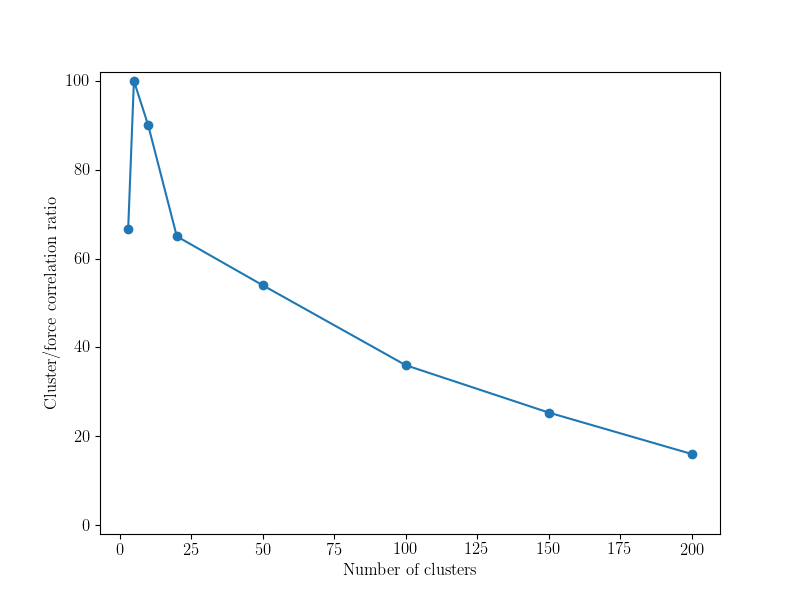

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.plot(cluster_numbers, cluster_results, "o-")
ax.set_ylim(-2, 102)
ax.set_xlabel(r'Number of clusters')
ax.set_ylabel(r'Cluster/force correlation ratio')
fig.savefig(f"cluster_ratio_{extract_element}.pdf")
fig.savefig(f"cluster_ratio_{extract_element}.png", dpi=300)